In [1]:
import numpy as np
import pickle

In [84]:
def evaluate_predictive_power(output_prediction):
    '''input: [] a list of true false classification of within-chunk reaction times '''
    '''output: chunk length as a function of sequence length '''
    chunk_classification = chunk_classification_model(output_prediction)     
    chunk_collect = get_model_chunk_collect(model_prediction, chunk_classification)
    
    return 
    
# at any point, guess the subject's chunk
def get_model_chunk_collect(model_prediction, withinchunk_classification):
    '''returns the chunks'''
    chunk_collect = []
    for i in range(0,len(withinchunk_classification)):
        chunk = []# initiate with an empty chunk 
        if withinchunk_classification[i] == False: # between chunk element
            chunk.append(model_prediction[i])
            nextidx  = i+1
            if nextidx<len(withinchunk_classification):
                while withinchunk_classification[nextidx] == True :
                    nextinst = model_prediction[nextidx]
                    chunk.append(nextinst)
                    nextidx = nextidx+1
                    if nextidx >=len(withinchunk_classification):
                        break;
            chunk_collect.append(chunk)
    
    return chunk_collect

# Comparing Human, HCM, and RNN

In [82]:
from sklearn.mixture import GaussianMixture
import random 

def chunk_classification_model(X):
    '''X: prediction sequence, a sequence of array with their prediction confidence translated into log likelihood
        output: classified chunks'''
    AIC, BIC, model = learn_gaussian_mixture(X.reshape(-1,1), n_mixture = 3)
    model = model[0]

    reaction_time = np.array(X)
    responsibilities = model.predict_proba(reaction_time.reshape(-1, 1))# likelihood of belonging to which gaussian mixture
    prediction = model.predict(reaction_time.reshape(-1, 1))# likelihood of belonging to which gaussian mixture

    within_chunk_model_index = np.argmin(model.means_)
    within_chunk = (prediction == within_chunk_model_index)
    p_within_chunk = responsibilities[:,within_chunk_model_index]

    return within_chunk # true for within-chunk

def learn_gaussian_mixture(X, n_mixture = 3):
    N = [n_mixture] #np.arange(1, 11)
    models = [None for i in range(len(N))]

    for i in range(len(N)):
        models[i] = GaussianMixture(N[i]).fit(X)

    # compute the AIC and the BIC
    AIC = [m.aic(X) for m in models]
    BIC = [m.bic(X) for m in models]
    
    return AIC, BIC, models


def generateseq(groupcond,seql = 600):
    seq = []
    if groupcond == 'c2':
        while len(seq) < seql:
            seq = seq + np.random.choice([[1,2],[3],[4]])
        return seq[0:seql]
    if groupcond == 'c3':
        while len(seq) < seql:
            seq = seq + np.random.choice([[1,2,3],[4]])
        return seq[0:seql]
    if groupcond == 'ind':
        while len(seq) < seql:
            seq = seq + [np.random.choice([1,2,3,4])]
        return seq[0:seql]

Evaluate chunk size on participants. 

In [94]:
file = open('../InputData/human_data/c3_chunks.pkl','rb')
c3subject = pickle.load(file)
file.close()

To output such a chunked sequence, as HCM already parses the sequence with the biggest explanatory unit that is consistent with the sequence instruction, this parsed sequence can also be used to evaluate the predictive power. 

Measure of predictive power: the size of learned representation in parsing a sequence. 



# Plot predictive power and chunk reuse curve on participants

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
dfc3 = {}
dfc3['ID'] = []
dfc3['time'] = []
dfc3['chunksize'] = []
for ID in list(c3subject.keys()):
    L_ID = []
#     training_length = []
    tl = 0
    for i in range(0, len(c3subject[ID])):
        L = len(c3subject[ID][i])
        tl = tl + L
        if tl>200 and tl < 800: 
            dfc3['ID'].append(ID)
            dfc3['time'].append(tl-200)
            L_ID.append(L)
            dfc3['chunksize'].append(np.mean(L_ID[len(L_ID)-30:len(L_ID)]))
#             training_length.append(tl)
dfc3 = pd.DataFrame.from_dict(dfc3)

predictive power increase is very rusted. There is a variability of chunk length as a function of training sequence. 

this is plotting the moving average

meanwhile, evaluate the parsing probability of chunks, as HCM learns through the sequence,

## RNN

In [77]:
# rnnchunk_classification
# rnnchunk_collect
import pandas as pd
import pickle
rnn_path = '../OutputData/c3_RNN.pkl'
with open(rnn_path, 'rb') as f:
    rnn = pickle.load(f)



In [78]:
# rnn['seq'] = list(rnn['seq'][0].flatten())
# rnn['prob'] = list(rnn['prob'][0].flatten())

lseq = []
pseq = []
for s in range(0, len(rnn['seq'])):
    lseq.append(rnn['seq'][s][0][0])
    pseq.append(rnn['prob'][s][0][0])

rnn['seq'] = lseq
rnn['prob'] = pseq
rnn = pd.DataFrame.from_dict(rnn)


In [79]:
dfrnn

NameError: name 'dfrnn' is not defined

In [80]:
rnn

,seq,prob,id,learning_rate,model_type
0,4,0.204204,0,0.001,model0
1,4,0.205711,0,0.001,model1
2,4,0.225858,0,0.001,model2
3,4,0.185939,0,0.001,model0
4,4,0.179243,0,0.001,model1
...,...,...,...,...,...
62995,3,0.240088,34,0.001,model1
62996,3,0.227047,34,0.001,model2
62997,1,0.311355,34,0.001,model0
62998,1,0.199910,34,0.001,model1


In [85]:
dfrnn = {}
dfrnn['time'] = []
dfrnn['chunksize'] = []
dfrnn['ID'] = []
dfrnn['lr'] = []
dfrnn['model'] = []

rnn_chunk_record = {}

n_sample = 35

for lr in [0.001]:
    for i in range(0,n_sample):
        for model in ['model0','model1','model2']:
            # get one sample here: 
            rt_rnn = -np.log(rnn[(rnn['id'] == i) & (rnn['learning_rate'] == lr) & (rnn['model_type'] == model)]['prob']) # how many consecutive predictions about the upcoming chunks can you make consecutively
            rnnchunk_classification = chunk_classification_model(np.array(rt_rnn))

            rnnmodel_prediction = list(rnn[(rnn['id'] == i) & (rnn['learning_rate'] == lr) & (rnn['model_type'] == model)]['seq'].astype('int'))
            rnnchunk_collect = get_model_chunk_collect(rnnmodel_prediction, rnnchunk_classification)
            rnn_chunk_record[i] = rnnchunk_collect

            L_ID = []
            tl = 0
            for j in range(0, len(rnnchunk_collect)):
                L = len(rnnchunk_collect[j])
                tl = tl + L
                dfrnn['time'].append(tl)
                L_ID.append(L)
                dfrnn['chunksize'].append(np.mean(L_ID[max(0,len(L_ID)-30):len(L_ID)]))
                dfrnn['ID'].append(i)
                dfrnn['lr'].append(lr)
                dfrnn['model'].append(model)

dfrnn = pd.DataFrame.from_dict(dfrnn)

In [96]:
HCM_path = '../OutputData/HCM_time_chunksize.pkl'
import pickle
with open(HCM_path, 'rb') as f:
    HCM_learn = pickle.load(f)
    
HCM_learn['smoothed']= []
for i in range(0,len(HCM_learn['chunksize'])):
    if HCM_learn['time'][i]%600 < 31 or i<31: 
        HCM_learn['smoothed'].append(np.mean(HCM_learn['chunksize'][i]))
    else:
        HCM_learn['smoothed'].append(np.mean(HCM_learn['chunksize'][i-30:i]))

# dfhcm = {}
# dfhcm['ID'] = []
# dfhcm['time'] = []
# dfhcm['chunksize'] = []

HCM_learn = pd.DataFrame.from_dict(HCM_learn)

In [97]:
PARSER_path = '../OutputData/PARSER_time_chunksize.pkl'
with open(PARSER_path, 'rb') as f:
    PARSER_learn = pickle.load(f)
    
PARSER_learn['smoothed']= []
for i in range(0,len(PARSER_learn['chunksize'])):
    if PARSER_learn['time'][i]%600 < 31 or i<31: 
        PARSER_learn['smoothed'].append(np.mean(PARSER_learn['chunksize'][i]))
    else:
        PARSER_learn['smoothed'].append(np.mean(PARSER_learn['chunksize'][i-30:i]))

# dfhcm = {}
# dfhcm['ID'] = []
# dfhcm['time'] = []
# dfhcm['chunksize'] = []

PARSER_learn = pd.DataFrame.from_dict(PARSER_learn)

Text(0.5, 0, 'Time')

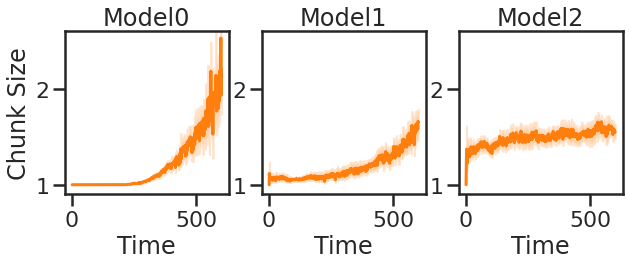

In [102]:
plt.figure(figsize = (10,3))

plt.subplot(1,3,1)
sns.set_style("ticks")
sns.set_context("poster")
tips = sns.load_dataset("tips")
g = sns.lineplot(x="time", y="chunksize", color = palette[1], data=dfrnn[dfrnn['model'] == 'model0'])
plt.title('Model0')
plt.ylim([0.9,2.6])
plt.ylabel('Chunk Size')
plt.xlabel('Time')


plt.subplot(1,3,2)
sns.set_style("ticks")
sns.set_context("poster")
palette = sns.color_palette("tab10")
g = sns.lineplot(x="time", y="chunksize", color = palette[1], data=dfrnn[dfrnn['model'] == 'model1'])
plt.ylim([0.9,2.6])
plt.title('Model1')
plt.ylabel('')
plt.xlabel('Time')

plt.subplot(1,3,3)
sns.set_style("ticks")
sns.set_context("poster")
palette = sns.color_palette("tab10")
g = sns.lineplot(x="time", y="chunksize", color = palette[1], data=dfrnn[dfrnn['model'] == 'model2'])
plt.title('Model2')
plt.ylabel('')
plt.ylim([0.9,2.6])
plt.xlabel('Time')


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (10,3))

plt.subplot(1,3,1)
sns.set_style("ticks")
sns.set_context("poster")
tips = sns.load_dataset("tips")
g = sns.lineplot(x="time", y="chunksize",color = palette[0], data=dfc3)
plt.title('Human')
plt.ylim([0.9,2.6])
plt.ylabel('Chunk Size')
plt.xlabel('Time')


plt.subplot(1,3,2)
sns.set_style("ticks")
sns.set_context("poster")
palette = sns.color_palette("tab10")
g = sns.lineplot(x="time", y="chunksize", color = palette[1], data=dfrnn[(dfrnn['lr'] == 0.001)& (dfrnn['model'] == 'model0')])
plt.ylim([0.9,2.6])
plt.title('RNN')
plt.ylabel('')
plt.xlabel('Time')

plt.subplot(1,3,3)
sns.set_style("ticks")
sns.set_context("poster")
palette = sns.color_palette("tab10")
g = sns.lineplot(x="time", y="smoothed",color = palette[4], data=HCM_learn)
plt.title('HCM')
plt.ylabel('')
plt.ylim([0.9,2.6])
plt.xlabel('Time')


In [ ]:
plt.figure(figsize = (10,3))

plt.subplot(1,3,1)
sns.set_style("ticks")
sns.set_context("poster")
tips = sns.load_dataset("tips")
g = sns.lineplot(x="time", y="chunksize",color = palette[0], data=dfc3)
plt.title('Human')
plt.ylim([0.9,2.6])
plt.ylabel('Chunk Size')
plt.xlabel('Time')

plt.subplot(1,3,2)
sns.set_style("ticks")
sns.set_context("poster")
palette = sns.color_palette("tab10")
g = sns.lineplot(x="time", y="smoothed",color = palette[2], data=PARSER_learn)
plt.title('PARSER')
plt.ylabel('')
plt.ylim([0.9,2.6])
plt.xlabel('Time')


plt.subplot(1,3,3)
sns.set_style("ticks")
sns.set_context("poster")
tips = sns.load_dataset("tips")
g = sns.lineplot(x="time", y="smoothed",color = palette[4], data=HCM_learn)
plt.title('HCM')
plt.ylim([0.9,2.6])
plt.ylabel('')
plt.xlabel('Time')



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (14,3))

plt.subplot(1,4,1)
sns.set_style("ticks")
sns.set_context("poster")
tips = sns.load_dataset("tips")
g = sns.lineplot(x="time", y="chunksize",color = palette[0], data=dfc3)
plt.title('Human')
plt.ylim([0.9,2.6])
plt.ylabel('Chunk Size')
plt.xlabel('Time')


plt.subplot(1,4,2)
sns.set_style("ticks")
sns.set_context("poster")
palette = sns.color_palette("tab10")
g = sns.lineplot(x="time", y="chunksize", color = palette[1], data=dfrnn[(dfrnn['lr'] == 0.001)& (dfrnn['model'] == 'model0')])
plt.ylim([0.9,2.6])
plt.title('RNN')
plt.ylabel('')
plt.xlabel('Time')

plt.subplot(1,4,3)
sns.set_style("ticks")
sns.set_context("poster")
palette = sns.color_palette("tab10")
g = sns.lineplot(x="time", y="smoothed",color = palette[4], data=HCM_learn)
plt.title('HCM')
plt.ylabel('')
plt.ylim([0.9,2.6])
plt.xlabel('Time')


plt.subplot(1,4,4)
sns.set_style("ticks")
sns.set_context("poster")
palette = sns.color_palette("tab10")
g = sns.lineplot(x="time", y="smoothed",color = palette[2], data=PARSER_learn)
plt.title('PARSER')
plt.ylabel('')
plt.ylim([0.9,2.6])
plt.xlabel('Time')

Text(0.5, 0, 'Time')

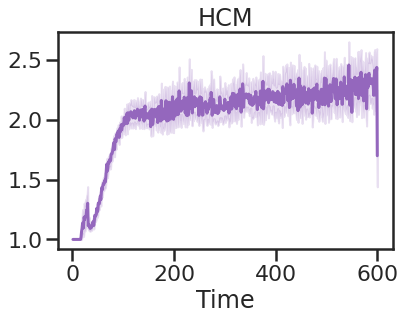

In [118]:
sns.set_style("ticks")
sns.set_context("poster")
palette = sns.color_palette("tab10")
g = sns.lineplot(x="time", y="smoothed",color = palette[4], data=HCM_learn)
plt.title('HCM')
plt.ylabel('')
#plt.ylim([0.9,2.6])
plt.xlabel('Time')

Text(0.5, 0, 'Time')

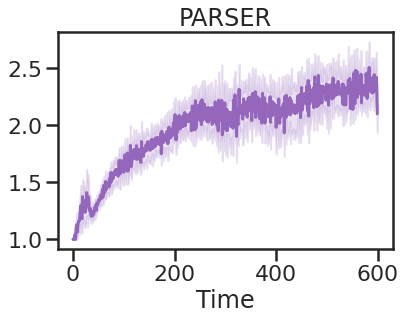

In [127]:
sns.set_style("ticks")
sns.set_context("poster")
palette = sns.color_palette("tab10")
g = sns.lineplot(x="time", y="smoothed",color = palette[4], data=PARSER_learn)
plt.title('PARSER')
plt.ylabel('')
#plt.ylim([0.9,2.6])
plt.xlabel('Time')

[Text(0, 0, 'Human'), Text(1, 0, 'RNN'), Text(2, 0, 'HCM')]

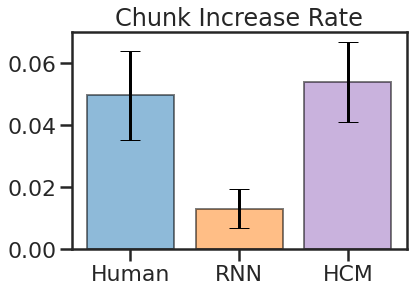

In [128]:
# Can evaluate the average growth rate in the first 300 time step. 
pl = 30
mean_human_chunk_increase = np.mean(dfc3['chunksize'].pct_change(periods=pl))
std_human_chunk_increase = np.std(dfc3['chunksize'].pct_change(periods=pl))/np.sqrt(600)

mean_rnn_chunk_increase = np.mean(dfrnn['chunksize'].pct_change(periods=pl))
std_rnn_chunk_increase = np.std(dfrnn['chunksize'].pct_change(periods=pl))/np.sqrt(600)

mean_hcm_chunk_increase = np.mean(HCM_learn['smoothed'].pct_change(periods=pl))
std_hcm_chunk_increase = np.std(HCM_learn['smoothed'].pct_change(periods=pl))/np.sqrt(600)

# sns.set_style("ticks")
# sns.set_context("poster")

palette = sns.color_palette("tab10")


# Create lists for the plot
Type = ['Human', 'RNN','HCM']
x_pos = np.arange(len(Type))
CTEs = [mean_human_chunk_increase, mean_rnn_chunk_increase, mean_hcm_chunk_increase]
error = [std_human_chunk_increase, std_rnn_chunk_increase, std_hcm_chunk_increase]


# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black',edgecolor = 'k', color = [palette[0],palette[1], palette[4]],capsize=10)
ax.set_title('Chunk Increase Rate')
#ax.set_ylabel('Chunk Increase Rate')
ax.set_xticks(x_pos)
ax.set_xticklabels(Type)
# ax.set_title('Chunk Increase Rate')

# # Save the figure and show
# plt.tight_layout()
# plt.savefig('Chunkincreaserate.png')
# plt.show()




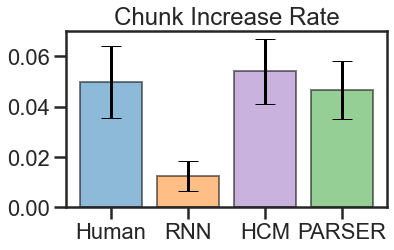

In [182]:
# Can evaluate the average growth rate in the first 300 time step. 
pl = 30
mean_human_chunk_increase = np.mean(dfc3['chunksize'].pct_change(periods=pl))
std_human_chunk_increase = np.std(dfc3['chunksize'].pct_change(periods=pl))/np.sqrt(600)

mean_rnn_chunk_increase = np.mean(dfrnn['chunksize'].pct_change(periods=pl))
std_rnn_chunk_increase = np.std(dfrnn['chunksize'].pct_change(periods=pl))/np.sqrt(600)

mean_hcm_chunk_increase = np.mean(HCM_learn['smoothed'].pct_change(periods=pl))
std_hcm_chunk_increase = np.std(HCM_learn['smoothed'].pct_change(periods=pl))/np.sqrt(600)

mean_parser_chunk_increase = np.mean(PARSER_learn['smoothed'].pct_change(periods=pl))
std_parser_chunk_increase = np.std(PARSER_learn['smoothed'].pct_change(periods=pl))/np.sqrt(600)

# sns.set_style("ticks")
# sns.set_context("poster")

palette = sns.color_palette("tab10")


# Create lists for the plot
Type = ['Human', 'RNN','HCM','PARSER']
x_pos = np.arange(len(Type))
CTEs = [mean_human_chunk_increase, mean_rnn_chunk_increase, mean_hcm_chunk_increase,mean_parser_chunk_increase]
error = [std_human_chunk_increase, std_rnn_chunk_increase, std_hcm_chunk_increase,std_parser_chunk_increase]


# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black',edgecolor = 'k', color = [palette[0],palette[1], palette[4], palette[2]],capsize=10)
ax.set_title('Chunk Increase Rate')
#ax.set_ylabel('Chunk Increase Rate')
ax.set_xticks(x_pos)
ax.set_xticklabels(Type)
# ax.set_title('Chunk Increase Rate')

# Save the figure and show
plt.tight_layout()
plt.savefig('Chunkincreaserate.png')
plt.show()




In [183]:
dfrnn

,time,chunksize,ID,lr,model
0,1,1.000000,0,0.001,model0
1,2,1.000000,0,0.001,model0
2,3,1.000000,0,0.001,model0
3,4,1.000000,0,0.001,model0
4,5,1.000000,0,0.001,model0
...,...,...,...,...,...
49782,585,1.600000,34,0.001,model2
49783,587,1.633333,34,0.001,model2
49784,588,1.633333,34,0.001,model2
49785,594,1.800000,34,0.001,model2


In [184]:
# Can evaluate the average growth rate in the first 300 time step. 
dfrnn0 = dfrnn[dfrnn['model'] == 'model0']['chunksize']
dfrnn1 = dfrnn[dfrnn['model'] == 'model1']['chunksize']
dfrnn2 = dfrnn[dfrnn['model'] == 'model2']['chunksize']

[Text(0, 0, 'Human'),
 Text(1, 0, 'Model0'),
 Text(2, 0, 'Model1'),
 Text(3, 0, 'Model2'),
 Text(4, 0, 'HCM'),
 Text(5, 0, 'PARSER')]

<Figure size 2160x720 with 0 Axes>

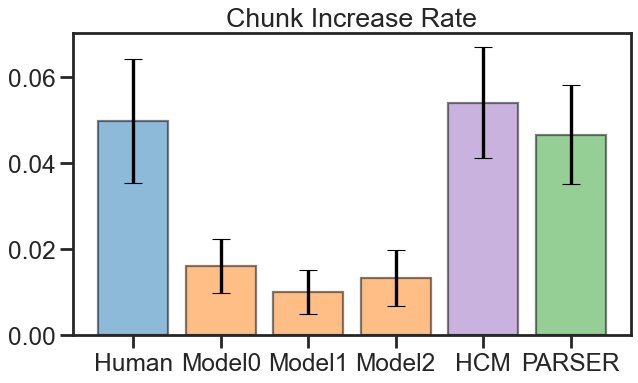

In [185]:

pl = 30

mean_human_chunk_increase = np.mean(dfc3['chunksize'].pct_change(periods=pl))
std_human_chunk_increase = np.std(dfc3['chunksize'].pct_change(periods=pl))/np.sqrt(600)

mean_rnn_chunk_increase = np.mean(dfrnn['chunksize'].pct_change(periods=pl))
std_rnn_chunk_increase = np.std(dfrnn['chunksize'].pct_change(periods=pl))/np.sqrt(600)

mean_hcm_chunk_increase = np.mean(HCM_learn['smoothed'].pct_change(periods=pl))
std_hcm_chunk_increase = np.std(HCM_learn['smoothed'].pct_change(periods=pl))/np.sqrt(600)

mean_parser_chunk_increase = np.mean(PARSER_learn['smoothed'].pct_change(periods=pl))
std_parser_chunk_increase = np.std(PARSER_learn['smoothed'].pct_change(periods=pl))/np.sqrt(600)



mean_rnn0_chunk_increase = np.mean(dfrnn0.pct_change(periods=pl))
std_rnn0_chunk_increase = np.std(dfrnn0.pct_change(periods=pl))/np.sqrt(600)

mean_rnn1_chunk_increase = np.mean(dfrnn1.pct_change(periods=pl))
std_rnn1_chunk_increase = np.std(dfrnn1.pct_change(periods=pl))/np.sqrt(600)

mean_rnn2_chunk_increase = np.mean(dfrnn2.pct_change(periods=pl))
std_rnn2_chunk_increase = np.std(dfrnn2.pct_change(periods=pl))/np.sqrt(600)

sns.set_style("ticks")
sns.set_context("poster")

palette = sns.color_palette("tab10")

plt.figure(figsize = (30,10))
# Create lists for the plot
Type = ['Human','Model0', 'Model1','Model2','HCM','PARSER']
x_pos = np.arange(len(Type))
CTEs = [mean_human_chunk_increase,mean_rnn0_chunk_increase, mean_rnn1_chunk_increase, mean_rnn2_chunk_increase, mean_hcm_chunk_increase,mean_parser_chunk_increase]
error = [std_human_chunk_increase,std_rnn0_chunk_increase, std_rnn1_chunk_increase, std_rnn2_chunk_increase,std_hcm_chunk_increase,std_parser_chunk_increase]


# Build the plot
fig, ax = plt.subplots(figsize=(9,5), dpi=80)
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black',edgecolor = 'k', color = [palette[0],palette[1],palette[1],palette[1],palette[4],palette[2]],capsize=8)
ax.set_title('Chunk Increase Rate')
#ax.set_ylabel('Chunk Increase Rate')
ax.set_xticks(x_pos)
ax.set_xticklabels(Type)


# ax.set_title('Chunk Increase Rate')

# # Save the figure and show
# plt.tight_layout()
# plt.savefig('Chunkincreaserate.png')
# plt.show()

In [186]:
HCM_path = '../OutputData/HCM_chunk.pkl'
import pickle
with open(HCM_path, 'rb') as f:
    hcm_chunk_record = pickle.load(f)

# Correlating reaction time data with prediction probability:

In [188]:
import pickle
import pandas as pd
with open('../OutputData/hcm_rnn_rt_p.pkl', 'rb') as f:
    data = pickle.load(f)
    
import numpy as np
    
dfsubject = pd.read_csv('../InputData/human_data/filtered_exp1.csv')
df = pd.DataFrame.from_dict(data)

In [189]:
import matplotlib.pyplot as plt
from numpy.random import randn
from numpy.random import seed
from scipy.stats import spearmanr
import math 
# seed random number generator
seed(1)

c_hcm = []
c_rnn = []

dfrt = {}
dfrt['ID'] = []
dfrt['rt'] = []
dfrt['lgphcm'] = []
dfrt['lgprnn'] = []


for ID in np.unique(dfsubject[dfsubject['condition'] == 2]['id']):
    rt_hcm = list(-np.log(np.array(df[(df['id'] == ID) & (df['rt'] <=1000)]['p_hcm'])))
    rt_subj = list(df[(df['id'] == ID) & (df['rt'] <=1000)]['rt'])
    rt_rnn = list(-np.log(np.array(df[(df['id'] == ID) & (df['rt'] <=1000)]['p_rnn'])))
    # calculate spearman's correlation
    corr_hcm, p_hcm = spearmanr(rt_subj, rt_hcm)
    corr_rnn, p_rnn = spearmanr(rt_subj, rt_rnn)

#     plt.plot(rt_subj,rt_hcm,'bo')
#     plt.plot(rt_subj,rt_rnn,'ro')
#     plt.show()
    dfrt['rt']+=rt_subj
    dfrt['ID']+= [ID]*len(rt_subj)
    dfrt['lgphcm'] += rt_hcm
    dfrt['lgprnn'] += rt_rnn
    if not math.isnan(p_hcm) and not math.isnan(p_rnn):
        c_hcm.append(corr_hcm)
        c_rnn.append(corr_rnn)

        
        
dfrt = pd.DataFrame.from_dict(dfrt)



In [190]:
print('RNN correlation: %.3f' % (np.mean(c_rnn)))
print('HCM correlation: %.3f' % (np.mean(c_hcm)))

# print('PARSER correlation: %.3f' % (np.mean(c_parser)))

RNN correlation: 0.085
HCM correlation: 0.165


In [191]:
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [192]:
%%R -i dfrt -o betashcm
library(lme4)
library(lmerTest)
m1<-lmer('rt ~ scale(lgphcm) + (scale(lgphcm) |ID)', data=dfrt)
betashcm<-summary(m1)
print(summary(m1))
#calculate BIC of model1
print(AIC(m1))
print(BIC(m1))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: "rt ~ scale(lgphcm) + (scale(lgphcm) |ID)"
   Data: dfrt

REML criterion at convergence: 313525.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-8.0589 -0.5943 -0.1006  0.5011  5.8796 

Random effects:
 Groups   Name          Variance Std.Dev. Corr 
 ID       (Intercept)   28326.8  168.31        
          scale(lgphcm)   283.8   16.85   -0.28
 Residual               11313.9  106.37        
Number of obs: 25722, groups:  ID, 47

Fixed effects:
              Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)    542.217     24.560  45.979  22.078  < 2e-16 ***
scale(lgphcm)   16.742      2.552  44.479   6.561 4.81e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
scl(lgphcm) -0.269
[1] 313537.6
[1] 313586.5


In [193]:
%%R -i dfrt -o betasrnn
library(lme4)
library(lmerTest)
m1<-lmer('rt ~ scale(lgprnn) + (scale(lgprnn) |ID)', data=dfrt)
betasrnn<-summary(m1)
print(summary(m1))
library(flexmix)

#calculate BIC of model1
print(AIC(m1))
print(BIC(m1))


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: "rt ~ scale(lgprnn) + (scale(lgprnn) |ID)"
   Data: dfrt

REML criterion at convergence: 314175.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.9484 -0.5887 -0.0914  0.5091  5.7920 

Random effects:
 Groups   Name          Variance Std.Dev. Corr 
 ID       (Intercept)   28046.6  167.47        
          scale(lgprnn)   133.2   11.54   -0.29
 Residual               11619.1  107.79        
Number of obs: 25722, groups:  ID, 47

Fixed effects:
              Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)    542.529     24.438  46.062  22.200  < 2e-16 ***
scale(lgprnn)    9.244      1.825  41.455   5.064  8.9e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
scl(lgprnn) -0.267
optimizer (nloptwrap) convergence code: 0 (OK)
Model failed to converge with max|grad| = 0.00957292 (tol = 0.002, com

<Figure size 216x144 with 0 Axes>

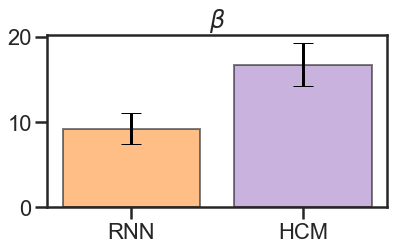

In [194]:
chcm_mean = 16.742
crnn_mean = 9.244

# Calculate the standard deviation
chcm_std = 2.552
crnn_std = 1.825


# Create lists for the plot
Type = ['RNN','HCM']
x_pos = np.arange(len(Type))
CTEs = [crnn_mean, chcm_mean]
error = [crnn_std,chcm_std]
plt.figure(figsize = (3,2))
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black',edgecolor = 'k', color = [palette[1], palette[4]], capsize=10)
ax.set_title(r'$\beta$')
ax.set_xticks(x_pos)
ax.set_xticklabels(Type)
#ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('Regression_Coefficient.png')
plt.show()

Checking the difference of having varying epsilon

In [196]:
df

,id,p_rnn,p_hcm,seq,rt,p_parser
0,1,0.250000,0.800000,4,2461,0.800000
1,1,0.250000,1.000000,3,577,0.250000
2,1,0.250000,0.250000,1,448,0.250000
3,1,0.250000,0.111111,3,738,0.163793
4,1,0.250000,0.115200,3,440,0.250000
...,...,...,...,...,...,...
28195,142,0.217355,0.800000,4,400,0.069792
28196,142,0.186241,0.000004,3,596,0.184191
28197,142,0.224228,0.800000,4,418,0.196937
28198,142,0.223425,0.000006,4,367,0.800000


In [197]:
df["p_hcm0"] = df["p_hcm"]
df["p_hcm1"] = df["p_hcm"]
df["p_hcm2"] = df["p_hcm"]

df.loc[df.p_hcm0 == 0.80, 'p_hcm0'] = 1-4*0.01
df.loc[df.p_hcm2 == 0.80, 'p_hcm2'] = 1-4*0.1


In [198]:
import matplotlib.pyplot as plt
from numpy.random import randn
from numpy.random import seed
from scipy.stats import spearmanr
import math 
# seed random number generator
seed(1)

c_hcm0 = []
c_hcm1 = []
c_hcm2 = []

dfrt = {}
dfrt['ID'] = []
dfrt['rt'] = []
dfrt['lgphcm0'] = []
dfrt['lgphcm1'] = []
dfrt['lgphcm2'] = []


for ID in np.unique(dfsubject[dfsubject['condition'] == 2]['id']):
    rt_hcm0 = list(-np.log(np.array(df[(df['id'] == ID) & (df['rt'] <=1000)]['p_hcm0'])))
    rt_hcm1 = list(-np.log(np.array(df[(df['id'] == ID) & (df['rt'] <=1000)]['p_hcm1'])))
    rt_hcm2 = list(-np.log(np.array(df[(df['id'] == ID) & (df['rt'] <=1000)]['p_hcm2'])))
    
    rt_subj = list(df[(df['id'] == ID) & (df['rt'] <=1000)]['rt'])

    # calculate spearman's correlation
    corr_hcm0, p_hcm0 = spearmanr(rt_subj, rt_hcm0)
    corr_hcm1, p_hcm1 = spearmanr(rt_subj, rt_hcm1)
    corr_hcm2, p_hcm2 = spearmanr(rt_subj, rt_hcm2)
    
    dfrt['rt']+=rt_subj
    dfrt['ID']+= [ID]*len(rt_subj)
    dfrt['lgphcm0'] += rt_hcm0
    dfrt['lgphcm1'] += rt_hcm1
    dfrt['lgphcm2'] += rt_hcm2
    if not math.isnan(p_hcm0) and not math.isnan(p_hcm1) and not math.isnan(p_hcm2):
        c_hcm0.append(corr_hcm0)
        c_hcm1.append(corr_hcm1)
        c_hcm2.append(corr_hcm2)
    
dfrt = pd.DataFrame.from_dict(dfrt)

In [199]:
print('HCM0 correlation: %.3f' % (np.mean(c_hcm0)))
print('HCM1 correlation: %.3f' % (np.mean(c_hcm1)))
print('HCM2 correlation: %.3f' % (np.mean(c_hcm2)))

HCM0 correlation: 0.165
HCM1 correlation: 0.165
HCM2 correlation: 0.165


In [200]:
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [201]:
%%R -i dfrt -o betashcm
library(lme4)
library(lmerTest)
m1<-lmer('rt ~ scale(lgphcm0) + (scale(lgphcm0) |ID)', data=dfrt)
betashcm<-summary(m1)
print(summary(m1))
#calculate BIC of model1
print(AIC(m1))
print(BIC(m1))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: "rt ~ scale(lgphcm0) + (scale(lgphcm0) |ID)"
   Data: dfrt

REML criterion at convergence: 313517.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-8.0621 -0.5944 -0.1012  0.5000  5.8823 

Random effects:
 Groups   Name           Variance Std.Dev. Corr 
 ID       (Intercept)    28329.9  168.31        
          scale(lgphcm0)   285.1   16.88   -0.28
 Residual                11310.3  106.35        
Number of obs: 25722, groups:  ID, 47

Fixed effects:
               Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)     542.215     24.561  45.978  22.076  < 2e-16 ***
scale(lgphcm0)   16.821      2.557  44.476   6.579 4.53e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
scl(lgphc0) -0.268
[1] 313529.5
[1] 313578.4


In [202]:
%%R -i dfrt -o betashcm
library(lme4)
library(lmerTest)
m1<-lmer('rt ~ scale(lgphcm1) + (scale(lgphcm1) |ID)', data=dfrt)
betashcm<-summary(m1)
print(summary(m1))
#calculate BIC of model1
print(AIC(m1))
print(BIC(m1))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: "rt ~ scale(lgphcm1) + (scale(lgphcm1) |ID)"
   Data: dfrt

REML criterion at convergence: 313525.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-8.0589 -0.5943 -0.1006  0.5011  5.8796 

Random effects:
 Groups   Name           Variance Std.Dev. Corr 
 ID       (Intercept)    28326.8  168.31        
          scale(lgphcm1)   283.8   16.85   -0.28
 Residual                11313.9  106.37        
Number of obs: 25722, groups:  ID, 47

Fixed effects:
               Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)     542.217     24.560  45.979  22.078  < 2e-16 ***
scale(lgphcm1)   16.742      2.552  44.479   6.561 4.81e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
scl(lgphc1) -0.269
[1] 313537.6
[1] 313586.5


In [203]:
%%R -i dfrt -o betashcm
library(lme4)
library(lmerTest)
m1<-lmer('rt ~ scale(lgphcm2) + (scale(lgphcm2) |ID)', data=dfrt)
betashcm<-summary(m1)
print(summary(m1))
#calculate BIC of model1
print(AIC(m1))
print(BIC(m1))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: "rt ~ scale(lgphcm2) + (scale(lgphcm2) |ID)"
   Data: dfrt

REML criterion at convergence: 313539.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-8.0536 -0.5944 -0.0999  0.5021  5.8751 

Random effects:
 Groups   Name           Variance Std.Dev. Corr 
 ID       (Intercept)    28320.0  168.29        
          scale(lgphcm2)   281.7   16.78   -0.28
 Residual                11320.0  106.40        
Number of obs: 25722, groups:  ID, 47

Fixed effects:
               Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)     542.219     24.557  45.985  22.080  < 2e-16 ***
scale(lgphcm2)   16.608      2.543  44.476   6.531 5.33e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
scl(lgphc2) -0.269
[1] 313551.1
[1] 313600


<Figure size 216x144 with 0 Axes>

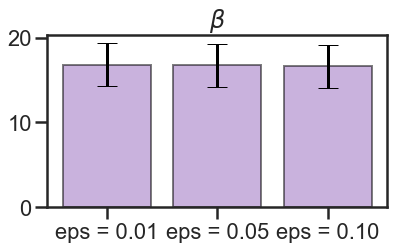

In [204]:
import seaborn as sns
chcm0_mean = 16.82
chcm1_mean = 16.74
chcm2_mean = 16.60

# Calculate the standard deviation
chcm0_std = 2.557
chcm1_std = 2.552
chcm2_std = 2.543

# Create lists for the plot
Type = ['eps = 0.01','eps = 0.05','eps = 0.10']
x_pos = np.arange(len(Type))
CTEs = [chcm0_mean, chcm1_mean, chcm2_mean]
error = [chcm0_std, chcm1_std, chcm2_std]

sns.set_style("ticks")
sns.set_context("poster")
plt.figure(figsize = (3,2))
# Build the plot
palette = sns.color_palette("tab10")


fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black',edgecolor = 'k', color = [palette[4], palette[4],palette[4]], capsize=10)
ax.set_title(r'$\beta$')
ax.set_xticks(x_pos)
ax.set_xticklabels(Type)
#ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.show()

In [205]:
import pickle
import pandas as pd
with open('../OutputData/hcm_rnn_rt_p.pkl', 'rb') as f:
    data = pickle.load(f)
    
import numpy as np
    
dfsubject = pd.read_csv('../InputData/human_data/filtered_exp1.csv')
df = pd.DataFrame.from_dict(data)

In [206]:
seed(1)
c_parser = []
lgpparser = []
c_rnn = []
lgprnn = []

for ID in np.unique(dfsubject[dfsubject['condition'] == 2]['id']):
    rt_rnn = list(-np.log(np.array(df[(df['id'] == ID) & (df['rt'] <=1000)]['p_rnn'])))
    rt_parser = list(-np.log(np.array(df[(df['id'] == ID) & (df['rt'] <=1000)]['p_parser'])))
    rt_subj = list(df[(df['id'] == ID) & (df['rt'] <=1000)]['rt'])
    corr_parser, p_parser = spearmanr(rt_subj, rt_parser)
    corr_rnn, p_rnn = spearmanr(rt_subj, rt_rnn)
    lgpparser += rt_parser
    lgprnn += rt_rnn
    if not math.isnan(p_parser):
        c_parser.append(corr_parser)
    if not math.isnan(p_rnn):
        c_rnn.append(corr_rnn)


<ipython-input-206-a4e05247ab95>:9: RuntimeWarning: divide by zero encountered in log
  rt_parser = list(-np.log(np.array(df[(df['id'] == ID) & (df['rt'] <=1000)]['p_parser'])))
<ipython-input-206-a4e05247ab95>:9: RuntimeWarning: divide by zero encountered in log
  rt_parser = list(-np.log(np.array(df[(df['id'] == ID) & (df['rt'] <=1000)]['p_parser'])))
<ipython-input-206-a4e05247ab95>:9: RuntimeWarning: divide by zero encountered in log
  rt_parser = list(-np.log(np.array(df[(df['id'] == ID) & (df['rt'] <=1000)]['p_parser'])))
<ipython-input-206-a4e05247ab95>:9: RuntimeWarning: divide by zero encountered in log
  rt_parser = list(-np.log(np.array(df[(df['id'] == ID) & (df['rt'] <=1000)]['p_parser'])))
<ipython-input-206-a4e05247ab95>:9: RuntimeWarning: divide by zero encountered in log
  rt_parser = list(-np.log(np.array(df[(df['id'] == ID) & (df['rt'] <=1000)]['p_parser'])))
<ipython-input-206-a4e05247ab95>:9: RuntimeWarning: divide by zero encountered in log
  rt_parser = list(-np.l

In [207]:
print('PARSER correlation: %.3f' % (np.mean(c_parser)))
print('RNN correlation: %.3f' % (np.mean(c_rnn)))

PARSER correlation: 0.128
RNN correlation: 0.085


In [208]:
dfrt['lgpparser'] = lgpparser
dfrt['lgprnn'] = lgprnn

In [209]:
dfrt

,ID,rt,lgphcm0,lgphcm1,lgphcm2,lgpparser,lgprnn
0,1,577,-0.000000,-0.000000,-0.000000,1.386294,1.386294
1,1,448,1.386294,1.386294,1.386294,1.386294,1.386294
2,1,738,2.197225,2.197225,2.197225,1.809151,1.386294
3,1,440,2.161086,2.161086,2.161086,1.386294,1.386294
4,1,406,2.214768,2.214768,2.214768,1.386294,1.386294
...,...,...,...,...,...,...,...
25717,142,400,0.040822,0.223144,0.510826,2.662229,1.526222
25718,142,596,12.416247,12.416247,12.416247,1.691780,1.680712
25719,142,418,0.040822,0.223144,0.510826,1.624871,1.495094
25720,142,367,12.014675,12.014675,12.014675,0.223144,1.498681


In [210]:
dfrt.to_csv('../OutputData/rt_model_comparison.csv')  

In [211]:
%%R -i dfrt -o betashcm
library(lme4)
library(lmerTest)
m1<-lmer('rt ~ scale(lgpparser) + (scale(lgpparser) |ID)', data=dfrt[!is.infinite(dfrt$lgpparser),])
betashcm<-summary(m1)
print(summary(m1))
#calculate BIC of model1
print(AIC(m1))
print(BIC(m1))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: "rt ~ scale(lgpparser) + (scale(lgpparser) |ID)"
   Data: dfrt[!is.infinite(dfrt$lgpparser), ]

REML criterion at convergence: 312807.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-8.0108 -0.5982 -0.0900  0.5151  5.7788 

Random effects:
 Groups   Name             Variance Std.Dev. Corr 
 ID       (Intercept)      28191.7  167.90        
          scale(lgpparser)   142.2   11.92   -0.04
 Residual                  11450.3  107.01        
Number of obs: 25640, groups:  ID, 47

Fixed effects:
                 Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)       543.027     24.501  45.978  22.163  < 2e-16 ***
scale(lgpparser)   11.070      1.874  44.783   5.907 4.36e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
scl(lgpprs) -0.034
[1] 312819.2
[1] 312868.1


<Figure size 216x144 with 0 Axes>

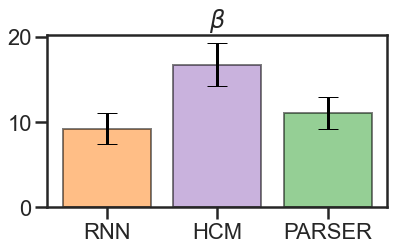

In [212]:
chcm_mean = 16.742
cparser_mean = 11.070
crnn_mean = 9.244

# Calculate the standard deviation
chcm_std = 2.552
crnn_std = 1.825
cparser_std = 1.874




# Create lists for the plot
Type = ['RNN','HCM','PARSER']
x_pos = np.arange(len(Type))
CTEs = [crnn_mean, chcm_mean,cparser_mean]
error = [crnn_std,chcm_std,cparser_std]
plt.figure(figsize = (3,2))
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black',edgecolor = 'k', color = [palette[1], palette[4],palette[2]], capsize=10)
ax.set_title(r'$\beta$')
ax.set_xticks(x_pos)
ax.set_xticklabels(Type)
#ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('Regression_Coefficient_Model_Comparison.png')
plt.show()